# Main Test Model
This code its the most recent and just has the necessary code to work

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import sys

In [15]:
class MaintenanceMarginTables():
    #obtained from https://www.binance.com/en/futures/trading-rules/perpetual/leverage-margin
    
    def __init__(self):
        ### Available Maintenance Margin tables ###
        self.BTCUSDT = None
        self.BTCBUSD = None
        ########### Fill each table ##############
        d = {'Tier': range(1,11),
         'PB' : [50000, 250000, 1000000, 10000000, 20000000, 50000000, 100000000, 200000000, 300000000, sys.maxsize], #Position Bracker (Notional Value in USDT) (top boundary)
         'ML' : [125, 100, 50, 20, 10, 5, 4, 3, 2, 1], #Max Leverage
         'MMR' : [0.004, 0.005, 0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.5], #Maintenance Margin Rate
         'MA' : [0, 50, 1300, 16300, 266300, 1266300, 2516300, 5016300, 25016300, 100016300] #Maintenance AMount (USDT)
        }
        self.BTCUSDT = pd.DataFrame(data = d)

        d = {'Tier': range(1,11),
         'PB' : [50000, 250000, 1000000, 7500000, 40000000, 100000000, 200000000, 400000000, 600000000, 1000000000], #Position Bracker (Notional Value in BUSD) (top boundary)
         'ML' : [50, 25, 20, 10, 6, 5, 4, 3, 2, 1], #Max Leverage
         'MMR' : [0.004, 0.005, 0.01, 0.025, 0.05, 0.1, 0.125, 0.15, 0.25, 0.5], #Maintenance Margin Rate
         'MA' : [0, 50, 1300, 16300, 203800, 2203800, 4703800, 9703800, 49703800, 199703800] #Maintenance AMount (BUSD)
        }
        self.BTCBUSD = pd.DataFrame(data = d)
        
    def get_table(self, pair):
        table = "self."+ pair.upper()
        return eval(table)
MMT = MaintenanceMarginTables()        

In [16]:
class Order():
    
    def __repr__(self):
        if self.position == 1:
            return "LONG"
        else:
            return "SHORT"
    
    def __init__(self, amount, leverage, expected_entry_price, position, created_at, 
                 fee_maker, fee_taker, use_fee, symbol, order_type = "MARKET"):
        self.symbol = symbol
        self.order_type = order_type
        self.amount = amount
        self.leverage = leverage
        self.amount_to_spend = self.amount/self.leverage #amount to really spend from my balance
        self.expected_entry_price = expected_entry_price
        self.position = position #long (1) or short (-1)
        self.fee_maker = fee_maker #comision for limit order
        self.fee_taker= fee_taker #comision for market order
        self.use_fee = use_fee #True or False
        self.created_at = created_at # creating position datetime
        ########### Open position params ###########
        self.entry_price = None
        self.opening_at = None #opening position datetime
        self.unlev_amount_to_buy_units = None
        self.amount_to_buy_units = None
        self.opening_fee_as_amount = None 
        self.opening_fee_as_units = None
        self.unlev_units = None
        self.units = None
        ########### Close position params ###########
        self.closing_at = None #close position datetime
        self.closing_fee_as_amount = None 
        self.closing_fee_as_units = None
        self.closing_price = None
        self.liquidated = False #Tells if position was liquidated
        self.liquidation_price = None
        
    def open_position(self, date, entry_price):
        self.opening_at = date # open position datetime
        if entry_price is None: 
            self.entry_price = self.expected_entry_price #for limit orders
        else:
            self.entry_price = entry_price #market orders    
        ##################### Works for long and short ##################    
        self.unlev_amount_to_buy_units = self.amount_to_spend/( 1 + self.leverage*self.fee_taker*self.use_fee )
        self.amount_to_buy_units = self.unlev_amount_to_buy_units*self.leverage
        self.opening_fee_as_amount = self.amount_to_buy_units*self.fee_taker*self.use_fee
        self.opening_fee_as_units = self.opening_fee_as_amount/self.entry_price
        self.unlev_units = self.unlev_amount_to_buy_units/self.entry_price
        self.units = self.unlev_units*self.leverage
        if self.position == 1:
            print("{} |  Buying {} for {}, leverage {}".format(self.opening_at, self.units, round(self.entry_price, 5), self.leverage))
        else:
            print("{} |  Selling {} for {}, leverage {}".format(self.opening_at, self.units, round(self.entry_price, 5), self.leverage))
        return self.units, self.opening_fee_as_amount
        
    def get_close_fee(self, price, as_amount= True):
        fee = self.units * self.fee_taker * self.use_fee
        if as_amount: fee*=price
        return fee
    
    def get_PnL(self, price, include_fee = False, as_amount = True):
        #get profit (by default doesnt include fee as Binance)
        PnL = self.position * self.units * (price - self.entry_price)
        fee = self.get_close_fee(price, as_amount= True) * include_fee
        profit = PnL - fee
        if not as_amount: profit/=price
        return profit
    
    def get_position_value(self, price, include_fee = True, as_amount = True):
        #gets the spent money and profits of the position (subtracts closing fee if True)
        profit = self.get_PnL(price = price, include_fee = include_fee, as_amount = True)
        pos_val = self.unlev_amount_to_buy_units + profit
        if not as_amount: pos_val /= price
        return pos_val
    
    def close_position(self, date, price, liquidate = False):
        self.closing_at = date
        self.closing_price = price
        self.closing_fee_as_amount = self.get_close_fee(price, as_amount = True)
        self.closing_fee_as_units = self.get_close_fee(price, as_amount = False)
        pos_value = self.get_position_value(price)
        if self.position == -1:
            print("{} |  Buying (closing) {} for {}".format(date, self.units, round(price, 5)))
        else:
            print("{} |  Selling (closing) {} for {}".format(date, self.units, round(price, 5)))  
        return pos_value
    
    def is_open(self):
        return self.closing_at is None
    
    def is_closed(self):
        return not self.is_open()
    
    def get_maintenance_margin(self, price):
        #this is an example of how to retrieve a table and the necessary row with the information.
        if self.symbol.upper() in "BTCUSDT":
            table = MMT.get_table("BTCUSDT") 
        elif self.symbol.upper() in "BTCBUSD":
            table = MMT.get_table("BTCBUSD")
        else:
            table = MMT.get_table(self.symbol)
        size = self.units*price #size of position
        #locate the corresponding row with size
        row = table.loc[ size >= table['PB'].shift(1).fillna(0) ].loc[ size < table['PB'] ]
        #get all the row values, these are the required to calculate maintenance margin.
        tier, pb, ml, mmr, ma = row.values[0]
        mm = size * mmr - ma
        return mm
    
    def calculate_margin_ratio(self, price):
        #when margin ratio == 1, that is the liquidation price
        maintenance_margin = self.get_maintenance_margin(price)
        balance = self.unlev_amount_to_buy_units #just for isolated mode (for cross you must use wallet)
        quantity = self.units
        mark_price = price #for simplicity
        entry_price = self.entry_price
        
        margin_ratio = maintenance_margin/( balance + self.position* quantity * ( mark_price - entry_price ))
        return margin_ratio
    
    def get_liquidation_price(self):
        #uses price instead of mark_price for simplicity
        #the liquidation price changes to farther when mark price gets close, so we  
        #execute this function many times to get close to the real one!!!!
        if self.liquidation_price is not None: return self.liquidation_price
        mark_price = self.entry_price
        pos = self.position
        entry_price = self.entry_price
        balance = self.unlev_amount_to_buy_units #just for isolated mode (for cross you must use wallet)
        quantity = self.units
        precision = 5 #more precision == closer you get to real liquidation price
        for i in range(precision):
            maintenance_margin = self.get_maintenance_margin(mark_price)
            liquidation_price = pos*( maintenance_margin - balance )/quantity + entry_price
            mark_price = liquidation_price
        self.liquidation_price = liquidation_price 
        return self.liquidation_price
    
    def should_liquidate(self, price): 
        if self.position == 1 and price <= self.get_liquidation_price():
            return True
        elif self.position == -1 and price >= self.get_liquidation_price():
            return True
        else:
            return False
    
    def liquidate_position(self, date):
        self.closing_at = date
        self.closing_price = self.liquidation_price
        self.liquidated = True
        if self.position == -1:
            print("{} |  Buying (liquidating) {} for {}".format(date, self.units, round(self.closing_price, 5)))
        else:
            print("{} |  Selling (liquidating) {} for {}".format(date, self.units, round(self.closing_price, 5))) 
        

In [17]:
class BinanceApi():

    def __init__(self, symbol, start, end, amount, use_fee = True, fee_maker=0, fee_taker=0):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_balance = amount
        self.available_balance = amount #keeps unlevered balance (real balance)
        self.open_orders = [] #stores open orders
        self.closed_orders= [] #stores closed orders
        self.liquidated_orders = 0 #stores count of liquidated orders
        self.trades = 0
        self.paid_fees = 0 #accumulates paid fees
        self.use_fee = use_fee
        self.fee_maker = fee_maker #limit orders fee
        self.fee_taker = fee_taker #market orders fee (higher)
        self.leverage = 1
        self.get_data()

    def get_data(self):
        raw = pd.read_csv("5m.csv", parse_dates = ["Date"], index_col = "Date").dropna()
        raw = raw.loc[self.start:self.end]
        raw = raw[["Close"]].rename(columns={"Close": "price"}) #just use these columns
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        raw["Hold Strategy"] = raw["returns"].cumsum().apply(np.exp) * self.initial_balance
        self.data = raw

    def plot_data(self, cols = None):  
        if cols is None:
            cols = "price"
        self.data[cols].plot(figsize = (12, 8), title = self.symbol)
    
    def get_values(self, bar):
        date = str(self.data.index[bar].date())
        price = round(self.data.price.iloc[bar], 5)
        return date, price
    
    def print_available_balance(self, bar):
        date, price = self.get_values(bar)
        print("{} | Current Balance: {}".format(date, round(self.available_balance, 2)))
        
    def buy_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        
        if self.get_position() in [0]: #open long position
            if amount is None: amount = units*price
            order = Order(amount = amount, 
              leverage = self.leverage, 
              expected_entry_price = price,
              position = 1, 
              created_at = date,       
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee,
              symbol = self.symbol)
            order.open_position(date = date, entry_price = price)
            self.paid_fees += order.opening_fee_as_amount
            self.open_orders.append(order)
            self.available_balance -= order.amount_to_spend
            self.trades += 1
        elif self.get_position() in [-1]: #closing short position
            order = self.open_orders[0]
            pos_value = order.close_position(date = date, price = price)
            self.paid_fees += order.closing_fee_as_amount
            self.available_balance += pos_value
            self.open_orders = []
            self.closed_orders.append(order)
                    
    def sell_instrument(self, bar, units = None, amount = None):
        date, price = self.get_values(bar)
        
        if self.get_position() in [0]: #open short position
            if amount is None: amount = units*price
            order = Order(amount = amount, 
              leverage = self.leverage, 
              expected_entry_price = price,
              position = -1, 
              created_at = date,       
              fee_maker = self.fee_maker, 
              fee_taker = self.fee_taker, 
              use_fee = self.use_fee,
              symbol = self.symbol)
            order.open_position(date = date, entry_price = price)
            self.paid_fees += order.opening_fee_as_amount
            self.open_orders.append(order)
            self.available_balance -= order.amount_to_spend
            self.trades += 1
        elif self.get_position() in [1]: #closing long position
            order = self.open_orders[0]
            pos_value = order.close_position(date = date, price = price)
            self.paid_fees += order.closing_fee_as_amount
            self.available_balance += pos_value
            self.open_orders = []
            self.closed_orders.append(order)
            
    def print_current_nav(self, bar):
        nav = self.get_nav(bar)
        print("{} |  Net Asset Value = {}".format(date, round(nav, 2)))
        
    def get_nav(self, bar):
        if len(self.open_orders) == 0: return self.available_balance
        date, price = self.get_values(bar)
        order = self.open_orders[0]
        pos_value = order.get_position_value(price = price, include_fee = True, as_amount = True)
        return self.available_balance + pos_value

    def get_position(self):
        if len(self.open_orders) == 0:
            return 0
        return self.open_orders[0].position
    
    def verify_not_liquidation(self, bar):
        date, price = self.get_values(bar)
        if self.get_position() == 0: return #currently no open positions
        order = self.open_orders[0]
        if order.should_liquidate(price):
            order.liquidate_position(date = date)
            self.open_orders = []
            self.closed_orders.append(order)
            self.liquidated_orders += 1

In [18]:
class IterativeBacktest(BinanceApi):

    # helper method
    def go_long(self, bar, units = None, amount = None):
        if self.get_position() == -1:
            self.go_neutral(bar) #if short position, go neutral first
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance * self.leverage
            self.buy_instrument(bar, amount = amount) # go long

    # helper method
    def go_short(self, bar, units = None, amount = None):
        if self.get_position() == 1:
            self.go_neutral(bar) # if long position, go neutral first
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.available_balance * self.leverage
            self.sell_instrument(bar, amount = amount) # go short
    
    def go_neutral(self, bar):
        if self.get_position() == 1: #if long, sell all
            self.sell_instrument(bar, units = self.open_orders[0].units)
        elif self.get_position() == -1: #if short, buy all
            self.buy_instrument(bar, units = self.open_orders[0].units)
            
    def calculate_metrics(self, bar):
        if not self.keep_metrics: return
        self.positions.append( self.position )
        self.navs.append( self.get_nav(bar) )
        
    def add_metrics_to_data(self):
        if not self.keep_metrics: return
        self.data["Position"] = self.positions + [0]*( self.data.shape[0] - len(self.positions) )
        self.data["NAV"] = self.navs + [0]*( self.data.shape[0] - len(self.positions) )
        
    def close_final_position(self, bar):
        date, price = self.get_values(bar)
        print(75 * "-")
        print("{} | +++ CLOSING FINAL POSITION +++".format(date))
        if self.get_position() in [-1]:
            self.buy_instrument(bar, units = self.open_orders[0].units)
        elif self.get_position() in [1]:    
            self.sell_instrument(bar, units = self.open_orders[0].units)
        perf = (self.available_balance - self.initial_balance) / self.initial_balance * 100
        self.print_available_balance(bar)
        print("{} | net performance (%) = {}".format(date, round(perf, 2) ))
        print("{} | number of trades executed = {}".format(date, self.trades)) 
        print("{} | number of liquidated orders = {}".format(date, self.liquidated_orders))
        print("{} | Amount spent on fee = {} ({}% of initial balance)".format(
            date, self.paid_fees, round(self.paid_fees/self.initial_balance*100, 2))
             ) 
        print(75 * "-")    
    
    def should_end_session(self):
        return abs(self.available_balance) < 0.1 and self.get_position() == 0 #no money and no positions
    
    def SMA(self, bar, close_all = False): 
        if close_all:
            self.close_final_position(bar)
            return
        if self.data["SMA_S"].iloc[bar] > self.data["SMA_L"].iloc[bar]: # signal to go long
            if self.get_position() in [0, -1]:
                self.go_long(bar, amount = "all") # go long with full amount
        elif self.data["SMA_S"].iloc[bar] < self.data["SMA_L"].iloc[bar]: # signal to go short
            if self.get_position() in [0, 1]:
                self.go_short(bar, amount = "all") # go short with full amount
        
    def test_sma_strategy(self, SMA_S, SMA_L, leverage = 1,keep_metrics = True):
        
        # nice printout
        stm = "Testing SMA strategy | {} | SMA_S = {} & SMA_L = {}".format(self.symbol, SMA_S, SMA_L)
        print("-" * 75)
        print(stm)
        print("-" * 75)
        
        # reset 
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.available_balance = self.initial_balance  # reset initial capital
        self.get_data() # reset dataset
        self.open_orders = []
        self.closed_orders = []
        self.paid_fees = 0
        self.liquidated_orders = 0
        self.leverage = leverage
        
        # prepare data
        self.data["SMA_S"] = self.data["price"].rolling(SMA_S).mean()
        self.data["SMA_L"] = self.data["price"].rolling(SMA_L).mean()
        self.data.dropna(inplace = True)
        
        #prepare metrics
        self.keep_metrics = keep_metrics
        self.positions, self.navs = [], []

        for bar in range(len(self.data)-1): # all bars (except the last bar)
            #date, price = self.get_values(bar) #useful to get current date and price
            self.verify_not_liquidation(bar) #verify current order isnt liquidated
            if self.should_end_session(): break #check if should end session  
            ############### Algorithm ###############   
            self.SMA(bar)
            ############## End Algorithm ############        
            self.calculate_metrics(bar)
            
        self.verify_not_liquidation(bar+1)           
        self.SMA(bar+1, close_all = True) # close the open position
        self.calculate_metrics(bar+1)
        self.add_metrics_to_data()

### Test

In [19]:
bc = IterativeBacktest(symbol = "BTCUSD", 
                       start = "2022-01-31", 
                       end = "2023-06-30", 
                       amount = 100000, 
                       use_fee= True,
                       fee_maker = 0.0002,
                       fee_taker = 0.0004
                    )

In [20]:
bc.test_sma_strategy(SMA_S = 50, SMA_L = 200, leverage = 1, keep_metrics = True)

---------------------------------------------------------------------------
Testing SMA strategy | BTCUSD | SMA_S = 50 & SMA_L = 200
---------------------------------------------------------------------------
2022-07-13 |  Selling 5.130732858735619 for 19482.6, leverage 1
2022-07-13 |  Buying (closing) 5.130732858735619 for 19830.9
2022-07-13 |  Buying 4.946474728858771 for 19830.9, leverage 1
2022-07-13 |  Selling (closing) 4.946474728858771 for 19605.6
2022-07-13 |  Selling 4.942519131314701 for 19605.6, leverage 1
2022-07-13 |  Buying (closing) 4.942519131314701 for 19740.0
2022-07-13 |  Buying 4.87129121900348 for 19740.0, leverage 1
2022-07-14 |  Selling (closing) 4.87129121900348 for 19748.5
2022-07-14 |  Selling 4.867395744218191 for 19748.5, leverage 1
2022-07-14 |  Buying (closing) 4.867395744218191 for 20199.8
2022-07-14 |  Buying 4.646097530210663 for 20199.8, leverage 1
2022-07-16 |  Selling (closing) 4.646097530210663 for 20690.8
2022-07-16 |  Selling 4.642382138343241 for

2022-08-02 |  Buying (closing) 2.8101601417193334 for 23949.0
2022-08-02 |  Buying 2.7009187532413788 for 23949.0, leverage 1
2022-08-02 |  Selling (closing) 2.7009187532413788 for 23264.0
2022-08-02 |  Selling 2.6987588821872075 for 23264.0, leverage 1
2022-08-02 |  Buying (closing) 2.6987588821872075 for 23513.1
2022-08-02 |  Buying 2.639441789435064 for 23513.1, leverage 1
2022-08-02 |  Selling (closing) 2.639441789435064 for 23268.9
2022-08-02 |  Selling 2.6373310802871752 for 23268.9, leverage 1
2022-08-03 |  Buying (closing) 2.6373310802871752 for 23588.7
2022-08-03 |  Buying 2.56374026927813 for 23588.7, leverage 1
2022-08-04 |  Selling (closing) 2.56374026927813 for 23844.0
2022-08-04 |  Selling 2.5616900971315664 for 23844.0, leverage 1
2022-08-05 |  Buying (closing) 2.5616900971315664 for 23148.3
2022-08-05 |  Buying 2.713558285650516 for 23148.3, leverage 1
2022-08-05 |  Selling (closing) 2.713558285650516 for 23018.0
2022-08-05 |  Selling 2.7113883070134506 for 23018.0, lev

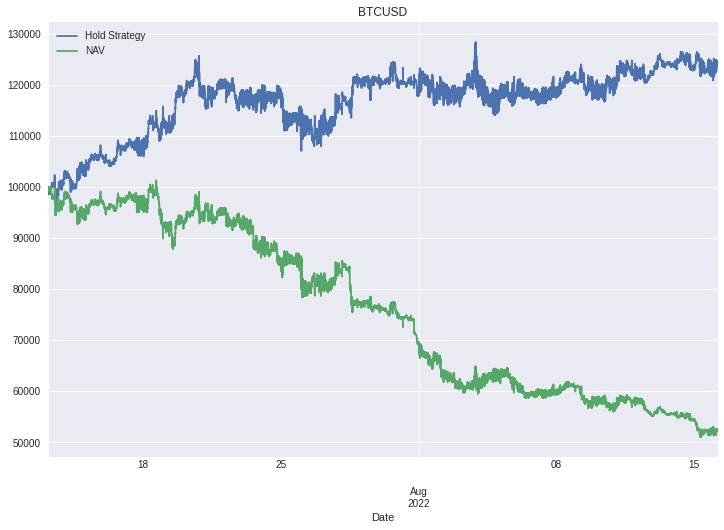

In [21]:
bc.plot_data(["Hold Strategy", "NAV"])